# Overfitting & Underfitting

<br>

- 앞선 4. 에서 일정 epoch동안 훈련하면 **val set에서 모델 성능이 최고점에 도달한 후 감소하기 시작**했음.
- 이건 모델이 **train set에 overfit 된 것.** 과대적합이 발생했다.
- train set에서 높은 성능을 얻을 수는 있지만, **우리가 진짜 원하는 것은 test set (또는 본적 없는 데이터)에 잘 일반화 되는 모델.**

<br>

- **과소적합(Underfitting)**? **test set에 대한 성능이 향상될 수 있을때 발생*. 발생 원인은 많음.
    - 모델이 너무 단순하거나, 규제가 너무 많거나, 오래 훈련하지 못했거나.*
    - 네트워크가 **train set에서 적절한 패턴을 학습하지 못한 경우**.
    
<br>

- 그렇다고 **모델을 너무 오래 훈련하면 과대적합이 발생함**. 
- test set에서 일반화 되지 못하는 패턴을 train set에서 학습하기 시작하는 셈.
- 과대적합과 과소적합 사이에서 적절한 균형을 잡아야 함. 

<br>

- 방지할 수 있는 방법들엔 뭐가 있을까?
    1. **더 많은 훈련 데이터 사용**. 많은 데이터로 학습할수록 자연적으로 일반화 성능이 좋아지게 됨.
    2. 데이터를 준비할 수 없다면 **정규화 같은 규제를 적용**하는 것. 모델이 저장할 수 있는 정보의 양과 종류에 제약을 거는 방법.
    3. **조기 종료**. 과대적합이 발생할 것 같은 시점에 학습을 종료하는 방법.
    4. **드롭-아웃**. 불필요한 유닛을 제거하는 방법.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

## Dataset load

<br>

- 이번엔 Embedding이 아닌 multi-hot encoding 해보자.
    - 정수 시퀀스를 0과 1로 이뤄진 벡터로 변환.
    - 시퀀스 [3,5]를 인덱스 3과 5만 1로 두고, 나머지는 모두 0인 10,000차원 벡터로 변환.
- 이 모델은 train set에 빠르게 과대적합 될 것. 어떻게 해결하는지 과정을 살펴보자.

In [3]:
NUM_WORDS = 1000

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

def multi_hot_sequences(sequences, dimension):
    # 0으로 채워진 (len(sequences), dimension)크기의 행렬 생성
    results = np.zeros((len(sequences), dimension))
    
    # results[i]의 특정 인덱스만 1로 설정.
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0
    return results

train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)

     multi-hot 벡터 중 하나를 살펴보자.
     단어 인덱스는 빈도 순으로 정렬되어 있음. 인덱스 0에 가까울수록 1이 많이 등장함.

C:\Users\skdbs\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['gulim'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


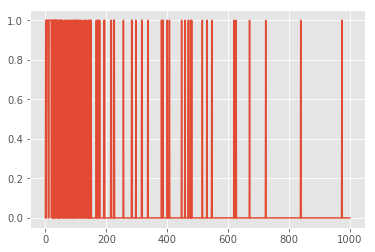

In [4]:
plt.plot(train_data[0])

## Overfitting Example

<br>

- 과대적합을 막는 **가장 간단한 방법은 모델의 규모를 축소**하는 것.
    - 모델에 있는 **trainable한 하이퍼 파라미터 수를 줄이는 것.**
    - 파라미터는 층(layer) 개수와 층의 유닛(unit)개수에 의해 결정. 신경망 구조 알고있으면 알죠?
- trainable한 하이퍼 파라미터 수를 **"용량"** 으로 부르기도 함.
- 직관적으로 생각해보면, 많은 파라미터를 가진 모델은 더 많은 "기억 용량"을 갖게 될 것.
    - 이런 모델은 훈련 샘플과 타겟 사이를 딕셔너리와 같은 매핑으로 완벽히 학습 할 수는 있음.
    - 히지만 처음 보는 데이터에서 예측할 땐 쓸모가 없어질 것.

            진짜 해결해야할 문제는 학습이 아닌 모델을 일반화 하는 것.

- 하지만 **네트워크의 기억 용량이 부족하다면 매핑을 쉽게 하지 못할 것.**
- 너무 많은 용량과 충분하지 않은 용량 사이의 균형을 잘 잡아야 한다.
- 그치만 이런 적절한 크기나 구조를 결정하는 마법은 없어요. 실험을 통해 **직접 발견해야 함.**

<br>

- 적당한 모델 크기를 찾으려면 **적은 수의 층과 파라미터로 시작**해, 
- **검증 손실이 감소할 때 까지 새로운 층을 추가하거나 층의 크기를 늘리는 방법**이 좋음.

### Baseline model build

In [5]:
baseline_model = keras.Sequential([
    # .summary 메서드 때문에 input_shape가 필요하다 함. 뭔소린지...
    keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                16016     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 16,305
Trainable params: 16,305
Non-trainable params: 0
_________________________________________________________________


In [6]:
with tf.device('/GPU:0'):
    baseline_history = baseline_model.fit(train_data, train_labels,
                                          epochs=20, batch_size=512,
                                          validation_data=(test_data, test_labels), verbose=2)

Epoch 1/20
49/49 - 1s - loss: 0.5703 - accuracy: 0.7340 - binary_crossentropy: 0.5703 - val_loss: 0.4391 - val_accuracy: 0.8216 - val_binary_crossentropy: 0.4391
Epoch 2/20
49/49 - 0s - loss: 0.3701 - accuracy: 0.8474 - binary_crossentropy: 0.3701 - val_loss: 0.3483 - val_accuracy: 0.8526 - val_binary_crossentropy: 0.3483
Epoch 3/20
49/49 - 0s - loss: 0.3223 - accuracy: 0.8661 - binary_crossentropy: 0.3223 - val_loss: 0.3336 - val_accuracy: 0.8593 - val_binary_crossentropy: 0.3336
Epoch 4/20
49/49 - 0s - loss: 0.3080 - accuracy: 0.8737 - binary_crossentropy: 0.3080 - val_loss: 0.3335 - val_accuracy: 0.8582 - val_binary_crossentropy: 0.3335
Epoch 5/20
49/49 - 0s - loss: 0.3014 - accuracy: 0.8760 - binary_crossentropy: 0.3014 - val_loss: 0.3284 - val_accuracy: 0.8599 - val_binary_crossentropy: 0.3284
Epoch 6/20
49/49 - 0s - loss: 0.2979 - accuracy: 0.8758 - binary_crossentropy: 0.2979 - val_loss: 0.3345 - val_accuracy: 0.8582 - val_binary_crossentropy: 0.3345
Epoch 7/20
49/49 - 0s - loss

### Tiny Model build

<br>

- 앞서 만든 baseline 모델과 비교하기 위해 
- 적은 수의 hidden unit을 가진 모델을 만들어보자.

In [7]:
smaller_model = keras.Sequential([
    keras.layers.Dense(4, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

smaller_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy', 'binary_crossentropy'])

smaller_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 4004      
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 4,029
Trainable params: 4,029
Non-trainable params: 0
_________________________________________________________________


    baseline 보다 하이퍼 파라미터 수가 약 4배 정도 적음.

In [9]:
# 같은 데이터를 써서 훈련해보자.
with tf.device('/GPU:0'):
    smaller_history = smaller_model.fit(train_data, train_labels,
                                        epochs=20, batch_size=512,
                                        validation_data=(test_data, test_labels), verbose=2)

Epoch 1/20
49/49 - 0s - loss: 0.6384 - accuracy: 0.6557 - binary_crossentropy: 0.6384 - val_loss: 0.5581 - val_accuracy: 0.7628 - val_binary_crossentropy: 0.5581
Epoch 2/20
49/49 - 0s - loss: 0.4863 - accuracy: 0.8073 - binary_crossentropy: 0.4863 - val_loss: 0.4359 - val_accuracy: 0.8258 - val_binary_crossentropy: 0.4359
Epoch 3/20
49/49 - 0s - loss: 0.3945 - accuracy: 0.8446 - binary_crossentropy: 0.3945 - val_loss: 0.3765 - val_accuracy: 0.8476 - val_binary_crossentropy: 0.3765
Epoch 4/20
49/49 - 0s - loss: 0.3510 - accuracy: 0.8579 - binary_crossentropy: 0.3510 - val_loss: 0.3504 - val_accuracy: 0.8554 - val_binary_crossentropy: 0.3504
Epoch 5/20
49/49 - 0s - loss: 0.3294 - accuracy: 0.8654 - binary_crossentropy: 0.3294 - val_loss: 0.3382 - val_accuracy: 0.8591 - val_binary_crossentropy: 0.3382
Epoch 6/20
49/49 - 0s - loss: 0.3175 - accuracy: 0.8700 - binary_crossentropy: 0.3175 - val_loss: 0.3335 - val_accuracy: 0.8594 - val_binary_crossentropy: 0.3335
Epoch 7/20
49/49 - 0s - loss

### Large Model build

<br>

- 앞선 모델들 보다 더 큰 모델(더 큰 용량을 가진 네트워크)을 만들어
- 과대적합이 얼마나 빠르게 발생하는지 봐보자.

In [10]:
bigger_model = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

bigger_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy', 'binary_crossentropy'])

bigger_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               512512    
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 775,681
Trainable params: 775,681
Non-trainable params: 0
_________________________________________________________________


    하이퍼 파라미터 수가
    작은 모델보다 약 192배, baseline 모델보다 약 47배 많음.

In [11]:
with tf.device('/GPU:0'):
    bigger_history = bigger_model.fit(train_data, train_labels,
                                      epochs=20, batch_size=512,
                                      validation_data=(test_data, test_labels), verbose=2)

Epoch 1/20
49/49 - 1s - loss: 0.4063 - accuracy: 0.8194 - binary_crossentropy: 0.4063 - val_loss: 0.3331 - val_accuracy: 0.8587 - val_binary_crossentropy: 0.3331
Epoch 2/20
49/49 - 0s - loss: 0.2911 - accuracy: 0.8790 - binary_crossentropy: 0.2911 - val_loss: 0.3261 - val_accuracy: 0.8583 - val_binary_crossentropy: 0.3261
Epoch 3/20
49/49 - 0s - loss: 0.2224 - accuracy: 0.9122 - binary_crossentropy: 0.2224 - val_loss: 0.3442 - val_accuracy: 0.8554 - val_binary_crossentropy: 0.3442
Epoch 4/20
49/49 - 0s - loss: 0.1077 - accuracy: 0.9663 - binary_crossentropy: 0.1077 - val_loss: 0.4141 - val_accuracy: 0.8497 - val_binary_crossentropy: 0.4141
Epoch 5/20
49/49 - 0s - loss: 0.0282 - accuracy: 0.9952 - binary_crossentropy: 0.0282 - val_loss: 0.5106 - val_accuracy: 0.8497 - val_binary_crossentropy: 0.5106
Epoch 6/20
49/49 - 0s - loss: 0.0061 - accuracy: 0.9997 - binary_crossentropy: 0.0061 - val_loss: 0.5967 - val_accuracy: 0.8522 - val_binary_crossentropy: 0.5967
Epoch 7/20
49/49 - 0s - loss

    정확도가 100%래요 ㅋㅋㅋ

## Train Loss & Validation Loss Visualization

<br>

- train loss(실선), val loss(점선)를 그래프로 그려서 한번 봐보자.
- val loss가 낮을수록 더 좋은 모델.

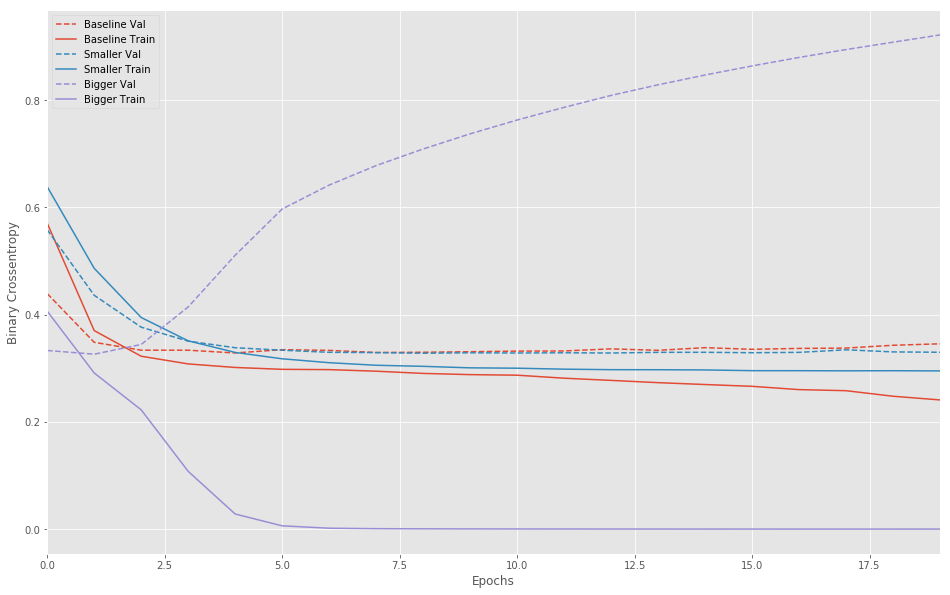

In [12]:
def plot_history(histories, key='binary_crossentropy'):
    plt.figure(figsize=(16, 10))
    
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')
    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_', ' ').title())
    plt.legend()
    
    plt.xlim([0, max(history.epoch)])
    
plot_history([('baseline', baseline_history), 
              ('smaller', smaller_history), 
              ('bigger', bigger_history)])

- baseline은 약 2.5 즈음에서 과적합이 발생되는거 같아 보임.
- smaller는 baseline보단 늦게 약 5.0 즈음에서 과적합이 발생되는거 같아 보임.
- bigger는 둘보다 더 빠른 약 1.0 즈음에서 과적합이 발생되는거 같아 보임.

- bigger는 첫 epoch 후로 과대적합이 시작되고, 이후로 훨씬 더 심각하게 과대적합이 발생하는 듯 하다.
    - 실제로 정확도가 100%로 나오는거 보면...
- 네트워크의 용량이 클수록 train set을 더 빠르게 모델링 할 수 있지만, 더 쉽게 overfit 됨.
    - train loss는 빠르게 낮아지지만, train loss와 val loss 사이 차이가 커진다는 의미.